In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import re

import time
import math

from scipy import stats

In [15]:
# create n-gram model object

class Model():
    def __init__(self, N):
        assert N > 0
        self.N = int(N)
        self.L = 0  # number of words in corpus
        self.G = 0  # number of (N-1)-grams (contexts)
        self.C = {} # all possible contexts [ (N-1)-grams ] { "context string" -> { "words": {"nextWord" -> frequency} , "size": sum(frequency) }
        self.W = {} # all possible words { "word" -> frequency }
        self.trained = False
        self.E = None
        return
    #
    def train(self, corpus, split=False):
        # todo -- handle start/end of sentences?
        print("training.")
        start_time = time.time()
        # expect corpus == 'all words in corpora'
        if not split: corpus = corpus.split()
        self.L = len(corpus)
        self.G = self.L-self.N+1
        for i in range(self.G-1):
            c = ' '.join(corpus[i:i+self.N-1]) # index by N-1 gram
            if self.C.get(c) is None: self.C[c] = {"words":{},"size":0} # new context
            self.C[c]["words"][corpus[i+self.N]] = self.C[c]["words"].get(corpus[i+self.N],0) + 1
            self.C[c]["size"] += 1
        for i in range(self.L):
            self.W[corpus[i]] = self.W.get(corpus[i],0) + 1
        print("training took {} seconds".format(time.time() - start_time))
        self.trained = True
        return self.trained
    #
    def ready(self):
        return self.trained
    #
    def eq1(self, wl, recompute=False):
        # wl = list of words w
        # need to compute -sum_c P(C=c|W=w)*logP(W=w|C=c)
        # using P(W=w|C=c) estimated with N-gram model
        #
        # P(C=c|W=w) = P(C=c and W=w) / P(W=w) = (self.C[c][w] / self.G) / (self.W[w] / self.L)
        # P(W=w|C=c) = P(W=w and C=c) / P(C=c) = self.C[c][w] / size(self.C[c])
        #
        # ez
#         e = [0]*len(wl)
#         for c in self.C:
#             for i,w in enumerate(wl):
#                 pcw = (self.C[c]["words"].get(w,0) / self.G) / (self.W[w] / self.L)
#                 pwc = self.C[c]["words"].get(w,0) / self.C[c]["size"]
#                 e[i] += pcw * (math.log(pwc,2) if pwc > 0 else 0)
#         return [-x for x in e]
        #
        # maybe this:
        # [1] =? -1/n sum log P(W=w|C=c_i)
        # n = frequency of w in corpus
        # c_i = context for the i-th occurrence of w
        t = {}
        if recompute:
            self.E = None
        if self.E is None:
            self.E = {w:0 for w in self.W}
            for c in self.C:
                # { "context string" -> { "words": {"nextWord" -> frequency} , "size": sum(frequency) }
                for w in self.C[c]["words"]:
                    # log2(number of times this word context appears) (number of N-grams ending in w)
                    # log2(number of times this context appears) (number of N-1-grams)
                    self.E[w] -= (math.log2(self.C[c]["words"][w]) - math.log2(self.C[c]["size"])) * self.C[c]["words"][w]
                    t[w] = t.get(w,0)+self.C[c]["words"][w]
            for w in t:
                if t[w] != self.W[w]:
                    print(w, t[w], self.W[w])
                    self.W[w] = t[w]
        return [self.E[w]/self.W[w] for w in wl]
    #
#


In [82]:
# for good measure, let's use a small English toy example and make sure our results are re-created
# using <https://www.corpusdata.org/formats.asp> linear text all samples

english_corpora = []
for folder in os.listdir('english/all'):
    for doc in [x for x in os.listdir('english/all/'+folder) if '.txt' in x]:
        with open('english/all/'+folder+'/'+doc) as f:
            english_corpora.append(f.read())
print(len(english_corpora))

# words = 0
# for c in english_corpora:
#     words += len(c.split())
# print(words) # rough estimate


2119


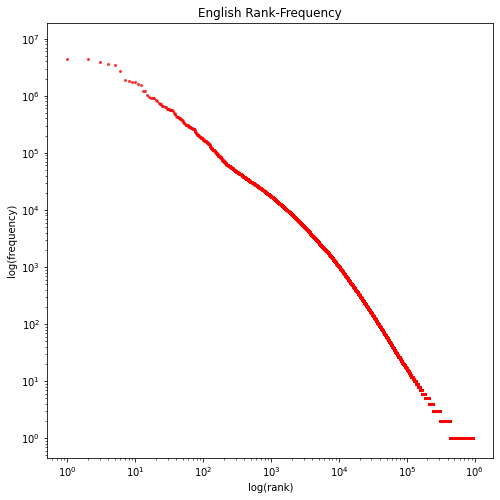

In [89]:
allenglish = ' '.join([re.sub('[!?.,;:”“"#()=+*\–\-/\d@<>]', '', c).lower() for c in english_corpora])

freqe = {}
for t in allenglish.split():
    freqe[t] = freqe.get(t, 0) + 1
freqe = [(freqe[k], k) for k in freqe]
freqe.sort(reverse=True)

tot = len(freqe)
fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.loglog([x[0] for x in freqe[:tot]],'o', alpha=0.8, markersize=3, color='r', markeredgecolor='none')
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
ax.set_title("English Rank-Frequency")
ax.set_xlabel("log(rank)")
ax.set_ylabel("log(frequency)")
# ax.grid(True)
plt.savefig('english-rank-freq')
plt.show()


In [84]:
n2 = Model(2)
n2.train( allenglish )
assert n2.ready()

n3 = Model(3)
n3.train( allenglish )
assert n3.ready()

# n4 = Model(4)
# n4.train( allenglish )
# assert n4.ready()

training.
training took 226.4675531387329 seconds
training.
training took 1216.483963727951 seconds


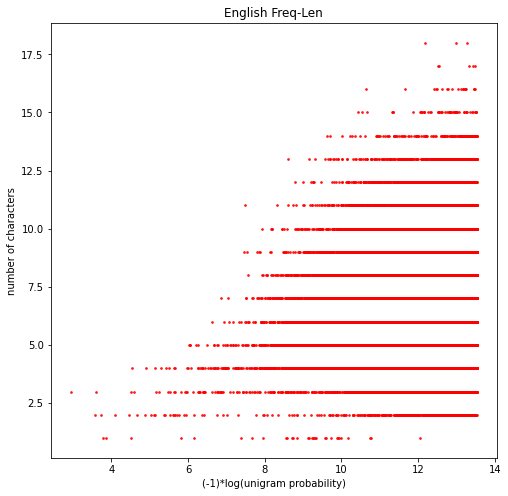

SpearmanrResult(correlation=0.12785853571946285, pvalue=1.324157056380339e-91)


In [99]:
tot = 25000
x = np.array([-math.log(e[0]/n2.L) for e in freqe[:tot]])
y = np.array([len(e[1]) for e in freqe[:tot]])

fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.scatter(x,y,s=3,c='r',alpha=0.8)
ax.set_title("English Freq-Len")
ax.set_xlabel("(-1)*log(unigram probability)")
ax.set_ylabel("number of characters")
# ax.grid(True)
plt.savefig('english-freq-len')
plt.show()

print(stats.spearmanr(x,y))

took 0.12044262886047363 seconds


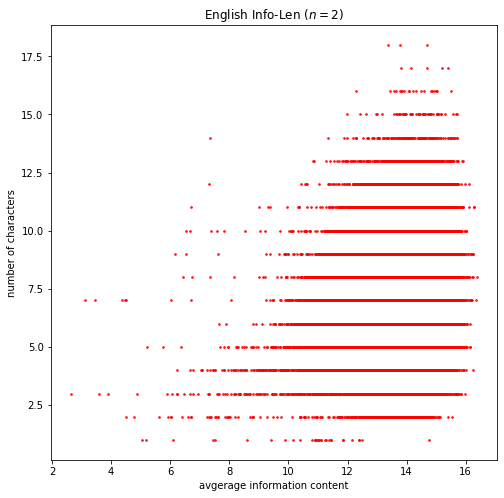

SpearmanrResult(correlation=0.17390483231740914, pvalue=5.789012010198284e-169)


In [90]:
tot = 25000
start_time = time.time()
info_content2 = n2.eq1([e[1] for e in freqe[:tot]])
print("took {} seconds".format(time.time() - start_time))

x = np.array(info_content2)
y = np.array([len(e[1]) for e in freqe[:tot]])

fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.scatter(x,y,s=3,c='r',alpha=0.8)
ax.set_title("English Info-Len ($n=2$)")
ax.set_xlabel("avgerage information content")
ax.set_ylabel("number of characters")
# ax.grid(True)
plt.savefig('english-info2-len')
plt.show()

print(stats.spearmanr(x, y))

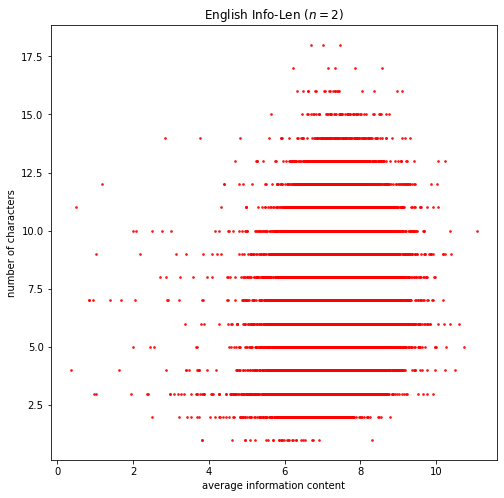

SpearmanrResult(correlation=0.14562117796204474, pvalue=1.5563973281346657e-118)


In [91]:
tot = 25000

info_content3 = n3.eq1([e[1] for e in freqe[:tot]])
x = np.array(info_content3)
y = np.array([len(e[1]) for e in freqe[:tot]])

fig = plt.figure(figsize=(8,8))
ax  = plt.axes()
ax.scatter(x,y,s=3,c='r',alpha=0.8)
ax.set_title("English Info-Len ($n=2$)")
ax.set_xlabel("average information content")
ax.set_ylabel("number of characters")
# ax.grid(True)
plt.savefig('english-info3-len')
plt.show()

print(stats.spearmanr(x, y))

In [95]:
print('hi')
# del english_corpora
# del split_english_corpora
# del n2
# del n3

hi


In [ ]:
# !!!!!
# DANGER ZONE BELOW
# !!!!!

In [42]:
english_corpora = []
for folder in os.listdir('english/all'):
    for doc in [x for x in os.listdir('english/all/'+folder) if '.txt' in x]:
        with open('english/all/'+folder+'/'+doc) as f:
            english_corpora.append(f.read())
#

# creates about 10Gb of overhead
indices = [] # (start,end+1) indices representing the chunks
split_english_corpora = []
curr = 0
for c in english_corpora:
    data = re.sub('[!?.,;:”“"#()=+*\–\-/\d@<>]', '', c).lower().split()
    split_english_corpora.extend(data)
    indices.append([curr,curr+len(data)])
    curr += len(data)
#
#split_english_corpora = np.array(split_english_corpora)
del english_corpora # recollect some space


In [52]:
# now we need to take chunks of smaller English data and see what's up

#
# THIS TAKES A LONG TIME
# my Model() code is not space-efficient,
# so multithreading is difficult
#

def trial(thresh):
    print('*')
    output = []
    # get random list of indices
    perm = np.random.permutation(list(range(0,len(indices))))
    sub_allenglish = []
    i = 0
    while i < len(perm) and len(sub_allenglish) < thresh:
        s,e = indices[perm[i]]
        sub_allenglish.extend(split_english_corpora[s:e])
        i += 1
    output.append(len(sub_allenglish))

    # zipf
    freqse = {}
    for t in sub_allenglish:
        freqse[t] = freqse.get(t, 0) + 1
    freqse = [(freqse[k], k) for k in freqse]
    freqse.sort(reverse=True)
    freqse = freqse[:25000]

    # freq-len
    x = np.array([-math.log(e[0]/len(sub_allenglish)) for e in freqse])
    y = np.array([len(e[1]) for e in freqse])
    output.append(stats.spearmanr(x,y))

    # info-len 2
    sn2 = Model(2)
    sn2.train( sub_allenglish , split=True )
    assert sn2.ready()
    info_content_sn2 = sn2.eq1([e[1] for e in freqse])
    x = np.array(info_content_sn2)
    y = np.array([len(e[1]) for e in freqse])
    output.append(stats.spearmanr(x,y))
    del sn2

    # info-len 3
    sn3 = Model(3)
    sn3.train( sub_allenglish , split=True )
    assert sn3.ready()
    info_content_sn3 = sn3.eq1([e[1] for e in freqse])
    x = np.array(info_content_sn3)
    y = np.array([len(e[1]) for e in freqse])
    output.append(stats.spearmanr(x,y))
    del sn3

    return output
#

start_time = time.time()

#R = {x*1000000:{'len':[], 'fl':[], 'il2':[], 'il3':[]} for x in range(5,105,5)} # 5,105,5
R = {x*1000000:{'len':[], 'fl':[], 'il2':[], 'il3':[]} for x in [5,10,20,40,80]}
trials = 10
for thresh in R:
# too much memory
#     with mp.Pool(trials) as pool:
#         outlist = pool.map(trial, [thresh]*trials) # blocks
#     #
    outlist = []
    for t in range(trials):
        outlist.append( trial(thresh) )
    for t in outlist:
        for idx,key in enumerate(['len','fl','il2','il3']):
            R[thresh][key].append(t[idx])
    print('----- -----')
#

print("took {} seconds".format(time.time() - start_time))

#     # save results
#     R[thresh] = results
#     for key in results:
#         tot = 0
#         for sr in results[key]:
#             tot += sr.correlation
#             print(sr)
#         print(key, tot/len(results[key]))
#


*
training.
training took 6.147459268569946 seconds
george 344 345
allen 64 65
training.
training took 12.884363889694214 seconds
the 291824 291825
george 344 345
allen 64 65
*
training.
training took 4.502537488937378 seconds
p 90633 90634
one 14499 14500
training.
training took 7.109185695648193 seconds
of 109811 109812
one 14499 14500
p 90633 90634
*
training.
training took 4.481652021408081 seconds
tour 419 420
a 110977 110978
training.
training took 9.762854814529419 seconds
a 110977 110978
of 132207 132208
tour 419 420
*
training.
training took 4.517757177352905 seconds
to 144386 144387
mrs 151 152
training.
training took 9.899155378341675 seconds
to 144386 144387
mrs 151 152
hamblin 1 2
*
training.
training took 4.547790050506592 seconds
yes 604 606
training.
training took 10.192739009857178 seconds
we 14350 14351
yes 604 606
*
training.
training took 5.736448287963867 seconds
the 282707 282708
first 7340 7341
training.
training took 12.328105449676514 seconds
the 282707 282708


training.
training took 173.95812439918518 seconds
h 231112 231113
corporate 5017 5018
responsibility 5061 5062
*
training.
training took 84.76635336875916 seconds
n 9503 9504
reaching 2223 2224
training.
training took 177.26174116134644 seconds
the 4365219 4365220
reaching 2223 2224
n 9503 9504
*
training.
training took 92.68626260757446 seconds
she 151004 151005
fought 1768 1769
training.
training took 188.34780049324036 seconds
she 151004 151005
for 830537 830538
fought 1768 1769
*
training.
training took 89.60864400863647 seconds
of 1935777 1935778
commonwealth 494 495
training.
training took 175.57830548286438 seconds
of 1935777 1935778
court 11757 11758
commonwealth 494 495
*
training.
training took 86.82298874855042 seconds
promises 1431 1432
henceforth 104 105
training.
training took 187.29385447502136 seconds
bert 269 270
promises 1431 1432
henceforth 104 105
----- -----
took 6496.674805164337 seconds


In [56]:
for key in R:
    print(key, R[key], '\n')
    for kkey in ['fl','il2','il3']:
        for sr in R[key][kkey]:
            if sr.pvalue >= 0.001:
                print("found insignificant pvalue")
    print('')
#



5000000 {'len': [6750414, 5039504, 5044385, 5118430, 5049746, 6220721, 5437280, 5031604, 5055066, 5051365], 'fl': [SpearmanrResult(correlation=0.16976204458041058, pvalue=5.452899662447299e-161), SpearmanrResult(correlation=0.14303673130127817, pvalue=2.1657677778854044e-114), SpearmanrResult(correlation=0.1446117294893132, pvalue=6.602115923069813e-117), SpearmanrResult(correlation=0.13755903607028855, pvalue=7.301387406392265e-106), SpearmanrResult(correlation=0.12759334929786043, pvalue=3.1380337619398027e-91), SpearmanrResult(correlation=0.1905903962615524, pvalue=3.737600195610848e-203), SpearmanrResult(correlation=0.12395127529048365, pvalue=3.649027941161297e-86), SpearmanrResult(correlation=0.15746844890801942, pvalue=1.613240582235023e-138), SpearmanrResult(correlation=0.13968980819725765, pvalue=3.865124928915143e-109), SpearmanrResult(correlation=0.12216624414484842, pvalue=9.769962834131908e-84)], 'il2': [SpearmanrResult(correlation=0.05669399168837236, pvalue=2.94169978424

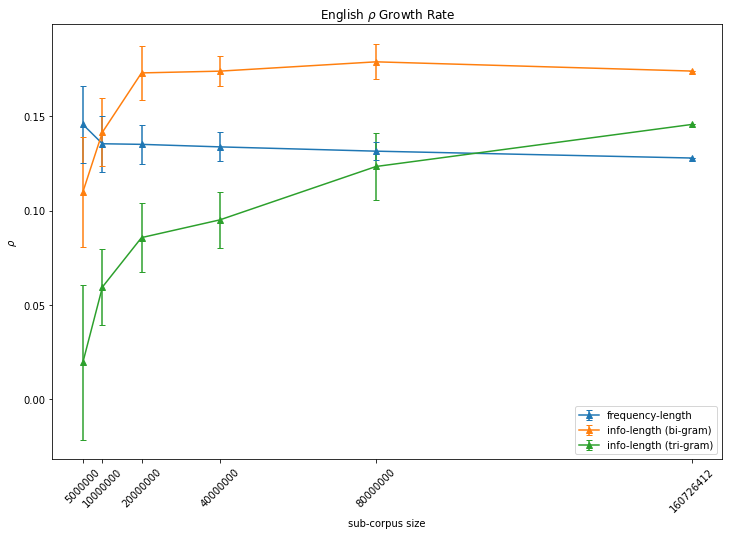

In [97]:
x = [x*1000000 for x in [5,10,20,40,80]]
x.append(indices[-1][1]) # also include entire corpus

fig = plt.figure(figsize=(12,8))
ax  = plt.axes()
for kkey in ['fl','il2','il3']:
    y = []
    e = []
    for key in R:
        sub = [sr.correlation for sr in R[key][kkey]]
        y.append(np.mean(sub))
        e.append(np.std(sub))
    if kkey == 'fl': y.append(0.12785853571946285) # values copy-pasted from before.
    elif kkey == 'il2': y.append(0.17390483231740914)
    else: y.append(0.14562117796204474)
    e.append(0)
    ax.errorbar(x,y,yerr=e,marker='^',capsize=3)
ax.set_title("English $\\rho$ Growth Rate")
ax.set_xlabel("sub-corpus size")
ax.set_ylabel("$\\rho$")
plt.xticks(x,rotation=45)
plt.ticklabel_format(useOffset=False,style='plain')
ax.legend(['frequency-length','info-length (bi-gram)','info-length (tri-gram)'])
plt.savefig('english-rho-growth')
plt.show()


In [51]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


In [49]:
# import gc
# gc.collect()
# del split_english_corpora

In [50]:
# for key in globals():
#     print("{:>30}: {:>8}".format(key, sizeof_fmt( sys.getsizeof(globals()[key]) )))